In [8]:
#Question 2

# import libraries
import pandas as pd
import numpy as np
import scipy as sp
import re

#Firstly we need to read reviews from hotel.dat file
hotel_raw_data = "./trip_advisor/hotel.dat"
# create a dataframe from the raw data
# But we need to process the data to a nicer format before making use of it
df_hotel = pd.read_table(hotel_raw_data,sep='\n',header=None, index_col=False)

In [173]:
# Create regular express pattern here to process tagged data in df_hotel 

# I will use regex.match function to create a list and then extract information from it
# it is learnt from the example programs provided in CSCI4146

# The pattern does not cover image tag since it is not required for this moment
pattern_tag=r'<([A-Z0-9.-_ ]+)>([A-Z0-9.%-_ ]+)'
regex = re.compile(pattern_tag, flags = re.IGNORECASE)

# an example here to get tag name
print df_hotel.iloc[2,0]
m= regex.match(df_hotel.iloc[2,0])
if(m):
    result =m.groups()
    print result[0]
 

<Date>Jan 8, 2009
Date


In [175]:
# Now go through the raw data and get all tag names 
index=0
raw_headers=[] # tags are stored in an array
raw_count = df_hotel.count()[0]

#
while (index < raw_count):
    m= regex.match(df_hotel.iloc[index,0])
    if (m):
        raw_headers.append(m.groups()[0])
    index=index+1

headers=set(raw_headers)

print list(headers)

['No. Helpful', 'Business service', 'Service', 'Author', 'Cleanliness', 'No. Reader', 'Check in / front desk', 'Overall', 'Value', 'Content', 'Rooms', 'Date', 'Location']


In [176]:
# Create a dataframe to store processed data
df_hotel_reviews=pd.DataFrame(index=range(raw_count/10) ,columns=list(headers))


In [13]:
# Go over the raw df and get reviews by account

index=0
user_Count=-1

while (index < raw_count):
    #run regular express test on each entry in the raw df
    m= regex.match(df_hotel.iloc[index,0])
    #jump to next row when hitting a new author
    if (m and m.groups()[0]=='Author'):
        user_Count=user_Count+1
    #store data by categories 
    if (m):
        result = m.groups()
        df_hotel_reviews.loc[user_Count,result[0]]=result[1]
    index=index+1

df_hotel_reviews


,No. Helpful,Business service,Service,Author,Cleanliness,No. Reader,Check in / front desk,Overall,Value,Content,Rooms,Date,Location
0,-1,4,5,mal51,5,-1,5,5,5,Loved the Melia Caribe Tropical I went to this...,3,"Jan 8, 2009",5
1,2,4,5,lucatony,5,2,4,5,3,Excellent Trip My wife and I just returned fro...,5,"Jan 6, 2009",5
2,-1,5,5,conniejo688,5,-1,5,5,5,Wonderfrul We (my husband and I) spent the Chr...,5,"Jan 6, 2009",5
3,2,-1,4,meginmd09,5,2,3,5,4,Relaxing and Wonderful Two families spent the ...,4,"Jan 2, 2009",5
4,4,-1,5,lynniepie,5,4,5,5,4,Great Royal getaway What a great pampered vaca...,5,"Dec 30, 2008",5
5,5,3,3,rightcoastgirl,3,6,3,4,-1,A Beautiful Place with A Few Quirks We stayed ...,3,"Dec 20, 2008",4
6,4,-1,1,C_Ville_VASean,1,10,1,1,1,"Ripped off, beware This place is not special, ...",3,"Dec 19, 2008",3
7,2,-1,-1,marinocmar,-1,8,-1,1,-1,terrible From day one we [my wife and I] had n...,-1,"Dec 16, 2008",-1
8,5,-1,4,vacationgirl001,4,6,3,5,4,A lovely place to stay After reading the repor...,4,"Dec 16, 2008",4
9,2,-1,1,CanadianTravelers1,1,6,1,2,2,Things Have Changed At This Resort - Timeshare...,1,"Dec 15, 2008",5


In [177]:
# Remove rows that have no data
# This trick was learnt from stackoverflow
# https://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-in-certain-columns-is-nan
df_hotel_reviews=df_hotel_reviews[pd.notnull(df_hotel_reviews['Author'])]




In [178]:
# Now need to crawl on webpages and retrieve account information by a given author name

# I also make use of BeautifulSoup, which is a Python library that helps to deal with html files.
# https://www.crummy.com/software/BeautifulSoup/bs4/doc/#searching-by-css-class
import urllib2
from urllib2 import  URLError, HTTPError

from bs4 import BeautifulSoup

# Create a pandas df for scrapted data as requirement in assignment
numOfAccounts=df_hotel_reviews.shape
numOfAccounts[0]
df_accounts=pd.DataFrame(None, index=range(df_hotel_reviews.shape[0]) ,columns=['Username','Age range','Sex','Location'])


# Define regular express patterns for extracting information from web component
pattern_age=r'([0-9- ]+) year old ([A-Z ]+)'
pattern_hometown=r'([A-Z0-9.,-_ ]+)'
regex_age = re.compile(pattern_age, flags = re.IGNORECASE)
regex_hometown = re.compile(pattern_hometown, flags = re.IGNORECASE)

# Define a function to fetch html resource by a given username
# Referred to https://docs.python.org/2/howto/urllib2.html for http error handling
def html_fetch(username):
    url="http://www.tripadvisor.ca/members/"+username
    request = urllib2.Request(url)
    try:
        response = urllib2.urlopen(request)
    except HTTPError as e:
        print('The server couldn\'t fulfill the request.')
        print('Error code: ', e.code)
    except URLError as e:
        print('Failed to reach the server.')
        print('Reason: ', e.reason)
    else:
        html = response.read()    
        return html
    


In [179]:
# now iterate the df_hotel_reviews and find account infomation from web
# I used BeautifulSoup to find specific html component with a given css class name
# the age, gender, and location are then extracted by regular expression match
for index, row in df_hotel_reviews.iterrows():
    
    html = html_fetch(row["Author"])
    if (html):
        soup = BeautifulSoup(html, 'html.parser')
        ageTag = soup.find(class_="ageSince")
        hometownTag = soup.find(class_="hometown")
        df_accounts.loc[index,'Username']=row["Author"]
        # print row["Author"]
        # print ageTag.contents
        # print hometownTag.contents

        if(ageTag.contents is not None and len(ageTag.contents)>1):
            m= regex_age.match(ageTag.contents[1].contents[0])
            if(m):
                result =m.groups()
                #print result[0]
                #print result[1]

                df_accounts.loc[index,'Age range']=result[0]
                df_accounts.loc[index,'Sex']=result[1]

        if(hometownTag.contents is not None and len(hometownTag.contents)>0):
            m= regex_hometown.match(hometownTag.contents[0].contents[0])
            if(m):
                result =m.groups()
                #print result[0]
                df_accounts.loc[index,'Location']=result[0]


In [53]:
print df_accounts
#df_hotel_reviews

                  Username Age range      Sex                 Location
0                    mal51     50-64  female    London, United Kingdom
1                 lucatony       NaN      NaN                  ontario
2              conniejo688       NaN      NaN            Champaign, IL
3                meginmd09       NaN      NaN                 Maryland
4                lynniepie     50-64  female        Poquoson, Virginia
5           rightcoastgirl     35-49  female             baltimore, md
6           C_Ville_VASean     25-34    male               C-Ville, VA
7               marinocmar       NaN      NaN                  florida
8          vacationgirl001     50-64  female             Hertfordshire
9       CanadianTravelers1     35-49  female                    CANADA
10        mandarinkaCanada       NaN      NaN                   Canada
11         Velocity_Blonde     50-64  female              Richmond, VA
12             Beachwoman1       NaN      NaN   Winston-Salem, NC, USA
13    

In [48]:
# write the dataframe to a csv file
df_accounts.to_csv("accounts.csv")

In [180]:
# Question 2.b

# Firstly we need to find out all age ranges
age_ranges = set(df_accounts["Age range"])
age_ranges


set()

In [83]:
# concatenate df_hotel_reviews and df_accounts so that we have all information in one df
df_info_all = pd.concat([df_hotel_reviews, df_accounts],axis=1, join='inner')

df_info_all


,No. Helpful,Business service,Service,Username,Cleanliness,No. Reader,Check in / front desk,Overall,Value,Content,Rooms,Date,Location,Username,Age range,Sex,Location
0,-1,4,5,mal51,5,-1,5,5,5,Loved the Melia Caribe Tropical I went to this...,3,"Jan 8, 2009",5,mal51,50-64,female,"London, United Kingdom"
1,2,4,5,lucatony,5,2,4,5,3,Excellent Trip My wife and I just returned fro...,5,"Jan 6, 2009",5,lucatony,NaN,NaN,ontario
2,-1,5,5,conniejo688,5,-1,5,5,5,Wonderfrul We (my husband and I) spent the Chr...,5,"Jan 6, 2009",5,conniejo688,NaN,NaN,"Champaign, IL"
3,2,-1,4,meginmd09,5,2,3,5,4,Relaxing and Wonderful Two families spent the ...,4,"Jan 2, 2009",5,meginmd09,NaN,NaN,Maryland
4,4,-1,5,lynniepie,5,4,5,5,4,Great Royal getaway What a great pampered vaca...,5,"Dec 30, 2008",5,lynniepie,50-64,female,"Poquoson, Virginia"
5,5,3,3,rightcoastgirl,3,6,3,4,-1,A Beautiful Place with A Few Quirks We stayed ...,3,"Dec 20, 2008",4,rightcoastgirl,35-49,female,"baltimore, md"
6,4,-1,1,C_Ville_VASean,1,10,1,1,1,"Ripped off, beware This place is not special, ...",3,"Dec 19, 2008",3,C_Ville_VASean,25-34,male,"C-Ville, VA"
7,2,-1,-1,marinocmar,-1,8,-1,1,-1,terrible From day one we [my wife and I] had n...,-1,"Dec 16, 2008",-1,marinocmar,NaN,NaN,florida
8,5,-1,4,vacationgirl001,4,6,3,5,4,A lovely place to stay After reading the repor...,4,"Dec 16, 2008",4,vacationgirl001,50-64,female,Hertfordshire
9,2,-1,1,CanadianTravelers1,1,6,1,2,2,Things Have Changed At This Resort - Timeshare...,1,"Dec 15, 2008",5,CanadianTravelers1,35-49,female,CANADA


In [197]:
# put all general ratings into lists by gender and age range
# then it would be easier to computer mean and std standard deviation for different groups
rating_female_18_24 = []
rating_male_18_24 = []
rating_female_25_34 = []
rating_male_25_34 = []
rating_female_35_49 = []
rating_male_35_49 = []
rating_female_50_64 = []
rating_male_50_64 = []

# lists for users missing profile data
rating_anonymous=[]
rating_female_noage = []
rating_male_noage = []
rating_no_gender_18_24 = []
rating_no_gender_25_34 = []
rating_no_gender_35_49 = []
rating_no_gender_50_64 = []

for index, row  in df_info_all.iterrows():
    sex=row["Sex"]
    sex=str(sex).strip()
    age=row["Age range"]
    age=str(age).strip()
    
    if (sex=='female' and age=='18-24'):
        rating_female_18_24.append(row["Overall"])
    elif (sex=='male' and age=='18-24'):
        rating_male_18_24.append(row["Overall"])
    elif (sex=='female' and age=='25-34'):
        rating_female_25_34.append(row["Overall"])
    elif (sex=='male' and age=='25-34'):
        rating_male_25_34.append(row["Overall"])
    elif (sex=='female' and age=='35-49'):
        rating_female_35_49.append(row["Overall"])
    elif (sex=='male' and age=='35-49'):
        rating_male_35_49.append(row["Overall"])
    elif (sex=='female' and age=='50-64'):
        rating_female_50_64.append(row["Overall"])
    elif (sex=='male' and age=='50-64'):
        rating_male_50_64.append(row["Overall"])
    elif (sex=="nan" and age=="nan"):
        rating_anonymous.append(row["Overall"])
    elif (sex=="female" and age=="nan"):
        rating_female_noage.append(row["Overall"])
    elif (sex=="male" and age=="nan"):
        rating_male_noage.append(row["Overall"])
    elif (sex=="nan" and age=="18-24"):
        rating_no_gender_18_24.append(row["Overall"])
    elif (sex=="nan" and age=="25-34"):
        rating_no_gender_25_34.append(row["Overall"])
    elif (sex=="nan" and age=="35-49"):
        rating_no_gender_35_49.append(row["Overall"])
    elif (sex=="nan" and age=="50-64"):
        rating_no_gender_50_64.append(row["Overall"])

        
print rating_female_noage 
print rating_male_noage 
print rating_no_gender_18_24 
print rating_no_gender_25_34 
print rating_no_gender_35_49 
print rating_no_gender_50_64 

# so now we know there is no records with partial personal information,
# the next step is to create df

[]
[]
[]
[]
[]
[]


In [201]:
# now  create the dataframe to store rating distribution
df_rating_dist = pd.DataFrame(None, index=range(9), columns=['Age range','Sex','Mean rating','s.d. rating', 'Group size'])
df_rating_dist

,Age range,Sex,Mean rating,s.d. rating,Group size
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN


In [202]:
# fill the df with data

df_rating_dist.loc[0,"Age range"]="18-24"
df_rating_dist.loc[0,"Sex"]="female"
rating_female_18_24 = map(float, rating_female_18_24)
df_rating_dist.loc[0,"Group size"]=len(rating_female_18_24)
if (len(rating_female_18_24)>0):
    df_rating_dist.loc[0,"Mean rating"] =sum(rating_female_18_24)/len(rating_female_18_24)
    df_rating_dist.loc[0,"s.d. rating"]= np.std(rating_female_18_24)


df_rating_dist.loc[1,"Age range"]="18-24"
df_rating_dist.loc[1,"Sex"]="male"
rating_male_18_24 = map(float, rating_male_18_24)
df_rating_dist.loc[1,"Group size"]=len(rating_male_18_24)
if (len(rating_male_18_24)>0):
    df_rating_dist.loc[1,"Mean rating"] =sum(rating_male_18_24)/len(rating_male_18_24)
    df_rating_dist.loc[1,"s.d. rating"]= np.std(rating_male_18_24)

df_rating_dist.loc[2,"Age range"]="25-34"
df_rating_dist.loc[2,"Sex"]="female"
rating_female_25_34 = map(float, rating_female_25_34)
df_rating_dist.loc[2,"Group size"]=len(rating_female_25_34)
if (len(rating_female_25_34)>0):
    df_rating_dist.loc[2,"Mean rating"] =sum(rating_female_25_34)/len(rating_female_25_34)
    df_rating_dist.loc[2,"s.d. rating"]= np.std(rating_female_25_34)


df_rating_dist.loc[3,"Age range"]="25-34"
df_rating_dist.loc[3,"Sex"]="male"
rating_male_25_34 = map(float, rating_male_25_34)
df_rating_dist.loc[3,"Group size"]=len(rating_male_25_34)
if (len(rating_male_25_34)>0):
    df_rating_dist.loc[3,"Mean rating"] =sum(rating_male_25_34)/len(rating_male_25_34)
    df_rating_dist.loc[3,"s.d. rating"]= np.std(rating_male_25_34)
    

df_rating_dist.loc[4,"Age range"]="35-49"
df_rating_dist.loc[4,"Sex"]="female"
rating_female_35_49 = map(float, rating_female_35_49)
df_rating_dist.loc[4,"Group size"]=len(rating_female_35_49)
if (len(rating_female_35_49)>0):
    df_rating_dist.loc[4,"Mean rating"] =sum(rating_female_35_49)/len(rating_female_35_49)
    df_rating_dist.loc[4,"s.d. rating"]= np.std(rating_female_35_49)
    

df_rating_dist.loc[5,"Age range"]="35-49"
df_rating_dist.loc[5,"Sex"]="male"
rating_male_35_49 = map(float, rating_male_35_49)
df_rating_dist.loc[5,"Group size"]=len(rating_male_35_49)
if (len(rating_male_35_49)>0):
    df_rating_dist.loc[5,"Mean rating"] =sum(rating_male_35_49)/len(rating_male_35_49)
    df_rating_dist.loc[5,"s.d. rating"]= np.std(rating_male_35_49)
    

df_rating_dist.loc[6,"Age range"]="50-64"
df_rating_dist.loc[6,"Sex"]="female"
rating_female_50_64 = map(float, rating_female_50_64)
df_rating_dist.loc[6,"Group size"]=len(rating_female_50_64)
if (len(rating_female_50_64)>0):
    df_rating_dist.loc[6,"Mean rating"] =sum(rating_female_50_64)/len(rating_female_50_64)
    df_rating_dist.loc[6,"s.d. rating"]= np.std(rating_female_50_64)

df_rating_dist.loc[7,"Age range"]="50-64"
df_rating_dist.loc[7,"Sex"]="male"
rating_male_50_64 = map(float, rating_male_50_64)
df_rating_dist.loc[7,"Group size"]=len(rating_male_50_64)
if (len(rating_male_50_64)>0):
    df_rating_dist.loc[7,"Mean rating"] =sum(rating_male_50_64)/len(rating_male_50_64)
    df_rating_dist.loc[7,"s.d. rating"]= np.std(rating_male_50_64)

    
#df_rating_dist.loc[8,"Age range"]="50-64"
#df_rating_dist.loc[7,"Sex"]="male"
rating_anonymous = map(float, rating_anonymous)
df_rating_dist.loc[8,"Group size"]=len(rating_anonymous)
if (len(rating_anonymous)>0):
    df_rating_dist.loc[8,"Mean rating"] =sum(rating_anonymous)/len(rating_anonymous)
    df_rating_dist.loc[8,"s.d. rating"]= np.std(rating_anonymous)


#Now write the df to a csv file

df_rating_dist.to_csv("rating_dist.csv")
df_rating_dist


,Age range,Sex,Mean rating,s.d. rating,Group size
0,18-24,female,4,1.41421,3
1,18-24,male,NaN,NaN,0
2,25-34,female,3.7234,1.31606,47
3,25-34,male,4.14286,1.2454,14
4,35-49,female,3.7375,1.28203,80
5,35-49,male,3.97222,1.09255,36
6,50-64,female,4.15385,0.948371,52
7,50-64,male,3.9375,1.11629,32
8,NaN,NaN,3.68143,1.36597,1287


In [ ]:
# Question 2.c 
# Some conclusions from this aggregation. 
# 1. Males tend to give higher rating than females except for the age range 50-64
# 2. Females at age range 25-49 tend to give relatively lower rating, and they count for almost half of the customers who 
#    rated and were willing to leave their gender and age information
# 3. Males at age range 25-34 gave the highest rating; however, the sample size is only 14
# 4. The sample size for people at age range 18-24 is too small to consider
# 5. Anonymous users tend to give lower rating.
# 6. Most users rate anonymously.

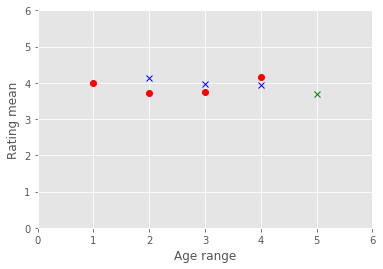

In [230]:
# Question 2.d
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
plt.style.use("ggplot")

# code referred to https://matplotlib.org/users/text_intro.html
# x-axis 
# 1 age 18_24
# 2 age 25_34
# 3 age 35_49
# 4 age 50_64
# 5 anonymous

# y-axis
# mean rating

# color schema
# male: blue x
# female : red circle
# anonymous: green

x1= 1
y1= df_rating_dist.loc[0,"Mean rating"]
x2= 2
y2= df_rating_dist.loc[2,"Mean rating"]
x3= 2
y3= df_rating_dist.loc[3,"Mean rating"]
x4= 3
y4= df_rating_dist.loc[4,"Mean rating"]
x5= 3
y5= df_rating_dist.loc[5,"Mean rating"]
x6= 4
y6= df_rating_dist.loc[6,"Mean rating"]
x7= 4
y7= df_rating_dist.loc[7,"Mean rating"]
x8= 5
y8= df_rating_dist.loc[8,"Mean rating"]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Age range')
ax.set_ylabel('Rating mean')

ax.plot(x1, y1, 'ro')
ax.plot(x2, y2, 'ro')
ax.plot(x3, y3, 'bx')
ax.plot(x4, y4, 'ro')
ax.plot(x5, y5, 'bx')
ax.plot(x6, y6, 'ro')
ax.plot(x7, y7, 'bx')
ax.plot(x8, y8, 'gx')


ax.axis([0, 6, 0, 6])
plt.show()


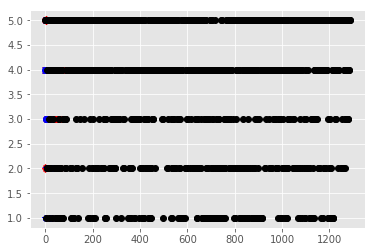

In [229]:
# we can also try plot all scattered points

# female plot color: red
# male plot color: blue
# age range 18-24 marker: d
# age range 25-34 marker: *
# age range 35_49 marker: x
# age range 50_64 marker: o

plt.plot(rating_female_18_24, marker='d', color='r', ls='')
plt.plot(rating_male_18_24, marker='d', color='b', ls='')
plt.plot(rating_female_25_34, marker='*', color='r', ls='')
plt.plot(rating_male_25_34, marker='*', color='b', ls='')
plt.plot(rating_female_35_49, marker='x', color='r', ls='')
plt.plot(rating_male_35_49, marker='x', color='b', ls='')
plt.plot(rating_female_50_64, marker='o', color='r', ls='')
plt.plot(rating_male_50_64, marker='o', color='b', ls='')
plt.plot(rating_anonymous, marker='o', color='black', ls='')
plt.show()

